You can read an overview of this Numerical Linear Algebra course in [this blog post](http://www.fast.ai/2017/07/17/num-lin-alg/).  The course was originally taught in the [University of San Francisco MS in Analytics](https://www.usfca.edu/arts-sciences/graduate-programs/analytics) graduate program.  Course lecture videos are [available on YouTube](https://www.youtube.com/playlist?list=PLtmWHNX-gukIc92m1K0P6bIOnZb-mg0hY) (note that the notebook numbers and video numbers do not line up, since some notebooks took longer than 1 video to cover).

You can ask questions about the course on [our fast.ai forums](http://forums.fast.ai/c/lin-alg).

# 5. Health Outcomes with Linear Regression

In [1]:
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import math, scipy, numpy as np
from scipy import linalg

## Diabetes Dataset

We will use a dataset from patients with diabates.  The data consists of 442 samples and 10 variables (all are physiological characteristics), so it is tall and skinny.  The dependent variable is a quantitative measure of disease progression one year after baseline.

This is a classic dataset, famously used by Efron, Hastie, Johnstone, and Tibshirani in their [Least Angle Regression](https://arxiv.org/pdf/math/0406456.pdf) paper, and one of the [many datasets included with scikit-learn](http://scikit-learn.org/stable/datasets/).

In [2]:
data = datasets.load_diabetes()

In [4]:
data.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [10]:
data['data'] #.shape #442 rows (patients) & 10 features

array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06832974, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286377, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04687948,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452837, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00421986,  0.00306441]])

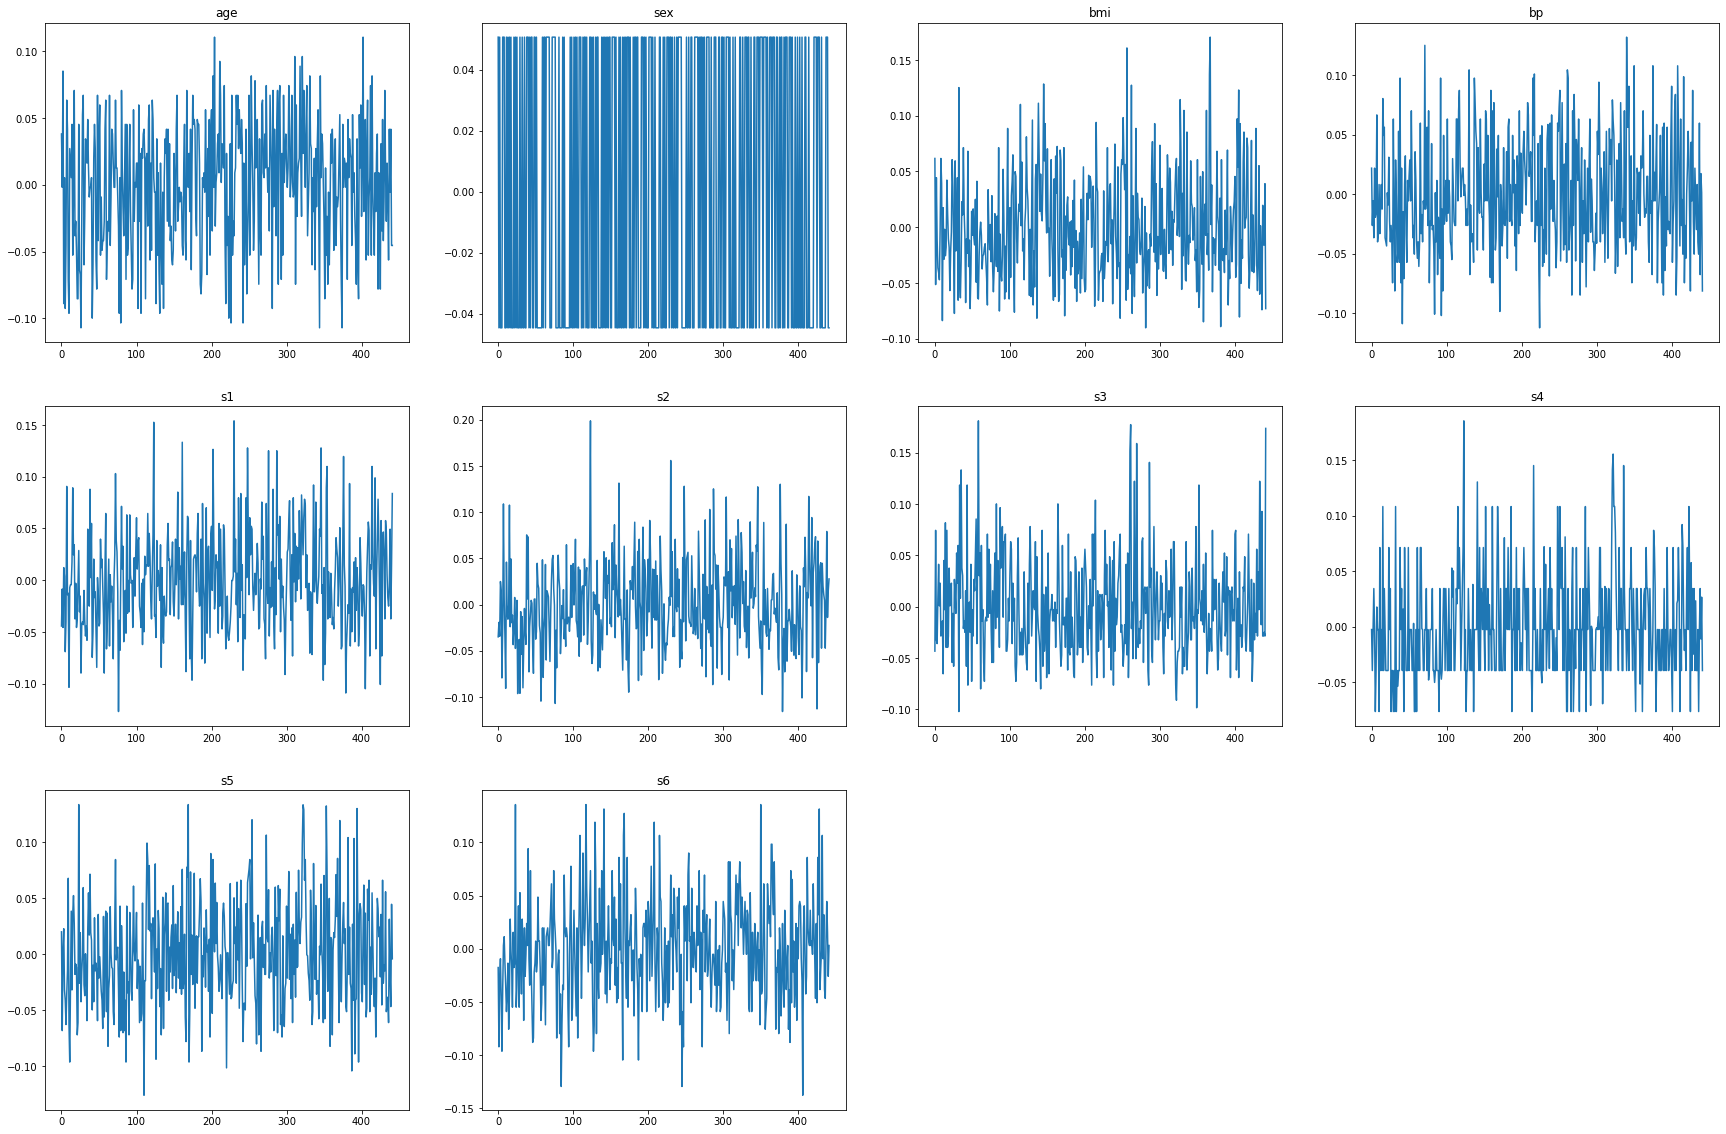

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.plot(data['data'][:,i])
    plt.title(data['feature_names'][i])

In [16]:
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [17]:
feature_names=['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [38]:
trn,test,y_trn,y_test = train_test_split(data.data, data.target, test_size=0.2)

In [39]:
trn.shape, test.shape, y_trn.shape, y_test.shape

((353, 10), (89, 10), (353,), (89,))

## Linear regression in Scikit Learn

Consider a system $X\beta = y$, where $X$ has more rows than columns.  This occurs when you have more data samples than variables.  We want to find $\hat{\beta}$ that minimizes: 
$$ \big\vert\big\vert X\beta - y \big\vert\big\vert_2$$

Let's start by using the sklearn implementation:

In [40]:
import time
def timecost(f, *arg):
    t1 = time.time()
    x= eval(f)(*arg)
    t2 = time.time()
    print(t2-t1)
    return x

In [41]:
regr = linear_model.LinearRegression()
x = timecost('regr.fit',trn, y_trn)
#%timeit regr.fit(trn, y_trn)

0.0009965896606445312


In [42]:
x.coef_

array([ -24.74441198, -250.13825023,  553.92543273,  284.14308846,
       -888.00580581,  561.09154889,  102.17509094,  143.62168217,
        774.19398267,  126.62880202])

In [43]:
pred = regr.predict(test)

It will be helpful to have some metrics on how good our prediciton is.  We will look at the mean squared norm (L2) and mean absolute error (L1).

In [44]:
def regr_metrics(act, pred):
    return (math.sqrt(metrics.mean_squared_error(act, pred)), 
     metrics.mean_absolute_error(act, pred))

In [45]:
regr_metrics(y_test, regr.predict(test))

(54.86664217580787, 43.554323523306444)

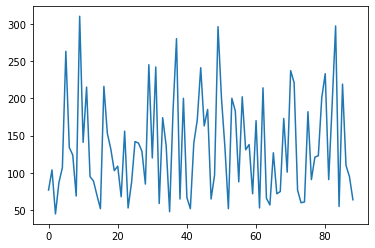

In [46]:
plt.plot(y_test)

## Polynomial Features

Linear regression finds the best coefficients $\beta_i$ for:

$$ x_0\beta_0 + x_1\beta_1 + x_2\beta_2 = y $$

Adding polynomial features is still a linear regression problem, just with more terms:

$$ x_0\beta_0 + x_1\beta_1 + x_2\beta_2 + x_0^2\beta_3 + x_0 x_1\beta_4 + x_0 x_2\beta_5 + x_1^2\beta_6 + x_1 x_2\beta_7 + x_2^2\beta_8 = y $$

We need to use our original data $X$ to calculate the additional polynomial features.

In [47]:
trn.shape

(353, 10)

Now, we want to try improving our model's performance by adding some more features.  Currently, our model is linear in each variable, but we can add polynomial features to change this.

In [53]:
poly = PolynomialFeatures(include_bias=False) #setting it false excludes constant columns

In [54]:
trn_feat = poly.fit_transform(trn)

In [55]:
trn_feat.shape

(353, 65)

In [56]:
poly.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x0^2',
       'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7',
       'x0 x8', 'x0 x9', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5',
       'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x2^2', 'x2 x3', 'x2 x4',
       'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x3^2', 'x3 x4',
       'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x4^2', 'x4 x5',
       'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x5^2', 'x5 x6', 'x5 x7',
       'x5 x8', 'x5 x9', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x7^2',
       'x7 x8', 'x7 x9', 'x8^2', 'x8 x9', 'x9^2'], dtype=object)

In [57]:
poly.get_feature_names_out(data.feature_names)

array(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'age^2', 'age sex', 'age bmi', 'age bp', 'age s1', 'age s2',
       'age s3', 'age s4', 'age s5', 'age s6', 'sex^2', 'sex bmi',
       'sex bp', 'sex s1', 'sex s2', 'sex s3', 'sex s4', 'sex s5',
       'sex s6', 'bmi^2', 'bmi bp', 'bmi s1', 'bmi s2', 'bmi s3',
       'bmi s4', 'bmi s5', 'bmi s6', 'bp^2', 'bp s1', 'bp s2', 'bp s3',
       'bp s4', 'bp s5', 'bp s6', 's1^2', 's1 s2', 's1 s3', 's1 s4',
       's1 s5', 's1 s6', 's2^2', 's2 s3', 's2 s4', 's2 s5', 's2 s6',
       's3^2', 's3 s4', 's3 s5', 's3 s6', 's4^2', 's4 s5', 's4 s6',
       's5^2', 's5 s6', 's6^2'], dtype=object)

In [58]:
', '.join(poly.get_feature_names_out(feature_names))

'age, sex, bmi, bp, s1, s2, s3, s4, s5, s6, age^2, age sex, age bmi, age bp, age s1, age s2, age s3, age s4, age s5, age s6, sex^2, sex bmi, sex bp, sex s1, sex s2, sex s3, sex s4, sex s5, sex s6, bmi^2, bmi bp, bmi s1, bmi s2, bmi s3, bmi s4, bmi s5, bmi s6, bp^2, bp s1, bp s2, bp s3, bp s4, bp s5, bp s6, s1^2, s1 s2, s1 s3, s1 s4, s1 s5, s1 s6, s2^2, s2 s3, s2 s4, s2 s5, s2 s6, s3^2, s3 s4, s3 s5, s3 s6, s4^2, s4 s5, s4 s6, s5^2, s5 s6, s6^2'

In [59]:
trn_feat.shape

(353, 65)

In [60]:
regr.fit(trn_feat, y_trn)

LinearRegression()

In [17]:
regr_metrics(y_test, regr.predict(poly.fit_transform(test)))

(56.37994753419146, 44.72189630043428)

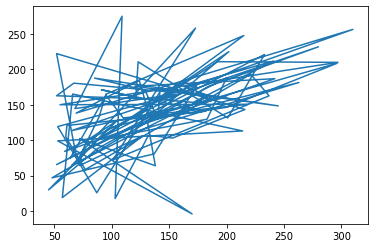

In [61]:
plt.plot(y_test, regr.predict(poly.fit_transform(test)))

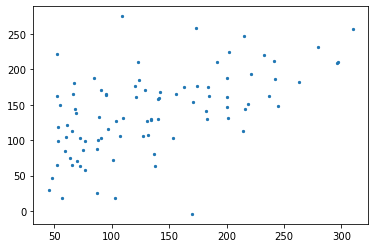

In [65]:
plt.scatter(y_test, regr.predict(poly.fit_transform(test)),s=5)

Time is squared in #features and linear in #points, so this will get very slow!

In [68]:
timecost('poly.fit_transform',trn)

0.0009553432464599609


array([[-6.00026317e-02,  5.06801187e-02,  1.53502873e-02, ...,
         9.45636908e-04,  3.31405020e-05,  1.16143190e-06],
       [ 5.62385987e-02, -4.46416365e-02, -5.79409337e-02, ...,
         8.02036138e-04, -1.25983954e-03,  1.97895780e-03],
       [-4.54724779e-02, -4.46416365e-02,  3.90621530e-02, ...,
         1.98277609e-03, -1.15463583e-03,  6.72382480e-04],
       ...,
       [ 2.35457526e-02,  5.06801187e-02, -3.74625043e-02, ...,
         9.45636908e-04,  4.15264899e-04,  1.82358509e-04],
       [ 1.62806757e-02, -4.46416365e-02,  1.75059115e-02, ...,
         1.38622266e-03, -4.01248454e-05,  1.16143190e-06],
       [ 5.98711371e-02,  5.06801187e-02,  2.28949719e-02, ...,
         1.56340196e-03,  7.76279984e-04,  3.85448292e-04]])

In [69]:
#%timeit poly.fit_transform(trn)

## Speeding up feature generation

We would like to speed this up.  We will use [Numba](http://numba.pydata.org/numba-doc/0.12.2/tutorial_firststeps.html), a Python library that compiles code directly to C.

**Numba is a compiler.**

#### Resources

[This tutorial](https://jakevdp.github.io/blog/2012/08/24/numba-vs-cython/) from Jake VanderPlas is a nice introduction.  Here Jake [implements a non-trivial algorithm](https://jakevdp.github.io/blog/2015/02/24/optimizing-python-with-numpy-and-numba/) (non-uniform fast Fourier transform) with Numba.

Cython is another alternative.  I've found Cython to require more knowledge to use than Numba (it's closer to C), but to provide similar speed-ups to Numba.

<img src="https://nbviewer.org/github/fastai/numerical-linear-algebra/blob/master/nbs/images/cython_vs_numba.png" alt="Cython vs Numba" style="width: 80%"/>

Here is a [thorough answer](https://softwareengineering.stackexchange.com/questions/246094/understanding-the-differences-traditional-interpreter-jit-compiler-jit-interp) on the differences between an Ahead Of Time (AOT) compiler, a Just In Time (JIT) compiler, and an interpreter.

### Experiments with vectorization and native code

Let's first get acquainted with Numba, and then we will return to our problem of polynomial features for regression on the diabates data set.

In [70]:
%matplotlib inline

In [92]:
import math, numpy as np, matplotlib.pyplot as plt
#from pandas_summary import DataFrameSummary
from scipy import ndimage

In [74]:
from numba import jit, vectorize, guvectorize, cuda, float32, void, float64

We will show the impact of:
- Avoiding memory allocations and copies (slower than CPU calculations)
- Better locality
- Vectorization

If we use numpy on whole arrays at a time, it creates lots of temporaries, and can't use cache. If we use numba looping through an array item at a time, then we don't have to allocate large temporary arrays, and can reuse cached data since we're doing multiple calculations on each array item.

In [75]:
# Untype and Unvectorized
def proc_python(xx,yy):
    zz = np.zeros(nobs, dtype='float32')
    for j in range(nobs):   
        x, y = xx[j], yy[j] 
        x = x*2 - ( y * 55 )
        y = x + y*2         
        z = x + y + 99      
        z = z * ( z - .88 ) 
        zz[j] = z           
    return zz

In [76]:
nobs = 10000
x = np.random.randn(nobs).astype('float32')
y = np.random.randn(nobs).astype('float32')

In [79]:
timecost('proc_python', x, y)

0.057817697525024414


array([66936.46   ,   740.24445,  9511.938  , ...,   156.56604,
       24494.434  , 41184.715  ], dtype=float32)

In [80]:
%timeit proc_python(x,y)   # Untyped and unvectorized

52.6 ms ± 736 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Numpy

Numpy lets us vectorize this:

In [81]:
# Typed and Vectorized
def proc_numpy(x,y):
    z = np.zeros(nobs, dtype='float32')
    x = x*2 - ( y * 55 )
    y = x + y*2         
    z = x + y + 99      
    z = z * ( z - .88 ) 
    return z

In [82]:
np.allclose( proc_numpy(x,y), proc_python(x,y), atol=1e-4 )

True

In [90]:
timecost('proc_numpy', x, y)

0.0009968280792236328


array([66936.46   ,   740.24414,  9511.939  , ...,   156.56595,
       24494.436  , 41184.72   ], dtype=float32)

In [91]:
%timeit proc_numpy(x,y)    # Typed and vectorized

21.2 µs ± 315 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Numba

Numba offers several different decorators.  We will try two different ones:

- `@jit`: very general
- `@vectorize`: don't need to write a for loop.  useful when operating on vectors of the same size

First, we will use Numba's jit  (just-in-time) compiler decorator, without explicitly vectorizing.  This avoids large memory allocations, so we have better locality:

In [93]:
@jit()
def proc_numba(xx,yy,zz):
    for j in range(nobs):   
        x, y = xx[j], yy[j] 
        x = x*2 - ( y * 55 )
        y = x + y*2         
        z = x + y + 99      
        z = z * ( z - .88 ) 
        zz[j] = z           
    return zz

In [94]:
z = np.zeros(nobs).astype('float32')
np.allclose( proc_numpy(x,y), proc_numba(x,y,z), atol=1e-4 )

True

In [110]:
timecost('proc_numba', x, y, z)

0.0


array([66936.46   ,   740.24445,  9511.938  , ...,   156.56604,
       24494.434  , 41184.715  ], dtype=float32)

In [111]:
%timeit proc_numba(x,y,z)

4.8 µs ± 42.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Now we will use Numba's `vectorize` decorator. Numba's compiler optimizes this in a smarter way than what is possible with plain Python and Numpy.

In [112]:
@vectorize
def vec_numba(x,y):
    x = x*2 - ( y * 55 )
    y = x + y*2         
    z = x + y + 99      
    return z * ( z - .88 ) 

In [113]:
np.allclose(vec_numba(x,y), proc_numba(x,y,z), atol=1e-4 )

True

In [114]:
%timeit vec_numba(x,y)

3.94 µs ± 46.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Numba is **amazing**.  Look how fast this is!

### Numba polynomial features

In [115]:
@jit(nopython=True)
def vec_poly(x, res):
    m,n=x.shape
    feat_idx=0
    for i in range(n):
        v1=x[:,i]
        for k in range(m): res[k,feat_idx] = v1[k]
        feat_idx+=1
        for j in range(i,n):
            for k in range(m): res[k,feat_idx] = v1[k]*x[k,j]
            feat_idx+=1

#### Row-Major vs Column-Major Storage

From this [blog post by Eli Bendersky](http://eli.thegreenplace.net/2015/memory-layout-of-multi-dimensional-arrays/):

"The row-major layout of a matrix puts the first row in contiguous memory, then the second row right after it, then the third, and so on. Column-major layout puts the first column in contiguous memory, then the second, etc.... While knowing which layout a particular data set is using is critical for good performance, there's no single answer to the question which layout 'is better' in general.

"It turns out that matching the way your algorithm works with the data layout can make or break the performance of an application.

"The short takeaway is: **always traverse the data in the order it was laid out**."

**Column-major layout**: Fortran, Matlab, R, and Julia

**Row-major layout**: C, C++, Python, Pascal, Mathematica

In [122]:
trn = np.asfortranarray(trn)
test = np.asfortranarray(test)

In [123]:
m,n=trn.shape
n_feat = n*(n+1)//2 + n
trn_feat = np.zeros((m,n_feat), order='F')
test_feat = np.zeros((len(y_test), n_feat), order='F')

In [124]:
vec_poly(trn, trn_feat)
vec_poly(test, test_feat)

In [125]:
regr.fit(trn_feat, y_trn)

LinearRegression()

In [126]:
regr_metrics(y_test, regr.predict(test_feat))

(60.495493850457265, 46.76059893565232)

In [127]:
%timeit vec_poly(trn, trn_feat)

13.5 µs ± 48.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Recall, this was the time from the scikit learn implementation PolynomialFeatures, which was created by experts: 

In [128]:
%timeit poly.fit_transform(trn)

182 µs ± 1.9 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [54]:
605/7.7

78.57142857142857

This is a big deal!  Numba is **amazing**!  With a single line of code, we are getting a 78x speed-up over scikit learn (which was optimized by experts).

## Regularization and noise

Regularization is a way to reduce over-fitting and create models that better generalize to new data.

### Regularization

Lasso regression uses an L1 penalty, which pushes towards sparse coefficients. The parameter $\alpha$ is used to weight the penalty term. Scikit Learn's LassoCV performs cross validation with a number of different values for $\alpha$.

Watch this [Coursera video on Lasso regression](https://www.coursera.org/learn/machine-learning-data-analysis/lecture/0KIy7/what-is-lasso-regression) for more info.

In [131]:
reg_regr = linear_model.LassoCV(n_alphas=10)

In [133]:
reg_regr.fit(trn_feat, y_trn)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52698.9618279885, tolerance: 177.68662836879432
  model = cd_fast.enet_coordinate_descent_gram(


LassoCV(n_alphas=10)

In [134]:
reg_regr.alpha_

0.010929373605336485

In [135]:
regr_metrics(y_test, reg_regr.predict(test_feat))

(54.245098153309826, 43.38383341880645)

### Noise

Now we will add some noise to the data

In [136]:
idxs = np.random.randint(0, len(trn), 10)

In [137]:
y_trn2 = np.copy(y_trn)
y_trn2[idxs] *= 10 # label noise

In [140]:
regr = linear_model.LinearRegression()
regr.fit(trn, y_trn)
regr_metrics(y_test, regr.predict(test))

(54.86664217580787, 43.55432352330644)

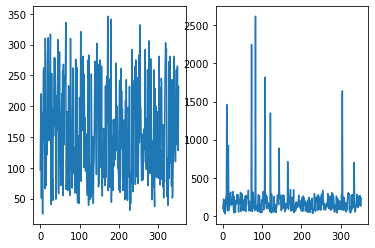

In [144]:
plt.subplot(1,2,1);plt.plot(y_trn)
plt.subplot(1,2,2);plt.plot(y_trn2)

In [145]:
regr.fit(trn, y_trn2)
regr_metrics(y_test, regr.predict(test))

(82.10463657753255, 68.93049293802872)

Huber loss is a loss function that is less sensitive to outliers than squared error loss.  It is quadratic for small error values, and linear for large values.

 $$L(x)= 
\begin{cases}
    \frac{1}{2}x^2,         & \text{for } \lvert x\rvert\leq \delta \\
    \delta(\lvert x \rvert - \frac{1}{2}\delta),  & \text{otherwise}
\end{cases}$$

In [146]:
hregr = linear_model.HuberRegressor()
hregr.fit(trn, y_trn2)
regr_metrics(y_test, hregr.predict(test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


(55.704029482642305, 44.6396272834163)

# End